# Package introductory notebook: implementing your own PDE problem

## Reminder on the mathematical context

A detailed introduction on learning PDE with PINNS is available in the [Background section](https://mia_jinns.gitlab.io/jinns/math_pinn.html) of the documentation. We simply recall the general statement: we wish to learn a solution $u$ to a PDE driven by the a differential operator $\mathcal{N}_\theta$ on a space domain $\Omega \subset \mathbb{R}^d$, a time interval $I = [0, T]$, with possible border condition on $\partial \Omega$ and initial condition $u(0, x) = u_0(x)$.

$$
\begin{equation}
\begin{cases}
\tag{PDE}
& \mathcal{N}_\theta[u](t, x) = 0, \quad \forall  t, x \in I\times \Omega, & \textrm{(Dynamic)}\\
& u(0, \cdot) = u_0(x), \quad \forall x \in \omega & \textrm{(Initial condition)} \\
& \mathcal{B}[u](t, dx) = f(dx), \quad \forall dx \in \partial \Omega, \forall t \in I & \textrm{(Boundary condition)}
\end{cases}
\end{equation}
$$

We wish to learn an estimator of the true solution $\hat{u}$ in the form of a parametric neural network with weights and biases $\nu$. The **jinns** package solves optimization of the following form:
$$
\hat{u} = u_\hat{\nu}\quad \textrm{with:} \quad \hat{\nu} \in \arg \min_{\nu} \left\{ L(\nu) = \Vert  \mathcal{N}_\theta[u_\nu] \Vert^2_{dyn} + w_{init} \Vert u_{\nu}(\cdot, 0) - u_0 \Vert^2_{init} + w_b \Vert \mathcal{B}[u_{\nu}] - f \Vert^2_{border} \right\},
$$
via stochastic gradient on mini-batches of $\Omega$, $\partial \Omega$ and $I$.

## Solving forward PDE problems with **jinns**

This tutorial focuses on solving forward problem with **jinns**. In order to define her PDE problem, a user needs to define:

 1. The neural network $u_\nu$ : **jinns** may work with any JAX-compatible package, although we recommand using the [equinox](https://pypi.org/project/equinox/) package.
 2. A `DataGenerator` object that handles the generation of the mesh on $I$, $\Omega$, $\partial \Omega$.
 3. A so-called `DynamicLoss`, which is an object defining the differential operator $\mathcal{N}_\theta[u_\nu]$, *i.e.* the PDE *dynamic* part of the global loss.
 4. The global loss $L(\nu)$ with boundary condition and initial condition.
 5. An optimization solver

We will go through all these steps with the toy example of the 1-D Burger equation defined on $I \times \Omega = [0, T] \times [-1, 1]$ as:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), & \textrm{ (Initial condition)}\\
u(t,-1)=u(t,1)=0, & \textrm{ (Boundary condition)}
\end{cases}
$$
where $\theta = 0.01 \pi$ is a single scalar equation parameters in this example.

Besides, we emphasize that in-depth Notebooks are available for several 2-D stationary and non-stationary PDEs:

 * Fokker-Planck equation (Ornstein-Ulhenbeck)
 * FisherKPP
 * Burger Equation
 * Navier-Stokes

In [1]:
import jinns
import jax
import jax.random as random
import jax.numpy as jnp
import equinox as eqx
import optax
from jaxopt import OptaxSolver
import matplotlib.pyplot as plt
from functools import partial


In [2]:
nu = 1 / (100 * jnp.pi)


### Setting the random key in JAX

If you are new to JAX, we recommand reading the documentation on [pseudo-random number generation](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html#pseudo-random-numbers-in-jax) and the differences with NumPy.

In [3]:
key = random.PRNGKey(42)


### Defining your neural network 

The **jinns** package requires a function $u(t, x, \nu, \theta)$ where $\nu$ are the neural network parameters, while $\theta$ are the equation parameters. Of course, the user is free to make the network depend on $\theta$ or not.

The following block-cells defines the function $u_\nu = f_{m, \nu} \circ \ldots \circ f_{1, \nu}$ where $m$ is the number of layers, and $f_{i, \nu}(x) = \sigma(A_ix + b_i)$ are simple linear functions followed by a non-linearity $\sigma$. We will work with the [equinox](https://pypi.org/project/equinox/) package which has PyTorch-like API but creates JAX-compatible function, which is required.

In our example, we chose arbitrarily $m=4$, with 20 neurons for each layer and $\sigma = \textrm{tanh}$. The dimension of the input $(t, x)$ is $d+1 = 2$. We use the `jinns.utils._pinn` module which facilitates the NN creation with the `create_PINN` function.

In [4]:
eqx_list = [
    [eqx.nn.Linear, 2, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(key, eqx_list, eq_type="nonstatio_PDE", dim_x=1)

Notice that we return an object from the PINN class. This object implements two methods:

 * `init_params()`: returns a set of randomly drawn neural network weights $\nu$ (useful for initialisation)
 * A `__call__` function, accessible through `u(t, x, params)`, which evaluates the neural net with parameters located at the key `"nn_params"` in the dictionary `params`, at points `t` and `x`.

Here is an example of how evaluate the neural network with randomly initialization

In [5]:
init_nn_params = u.init_params()
u_init = partial(u, params=init_nn_params)
u_init(t= jnp.zeros(1), x = jnp.zeros(1)) # u_init(0, 0)

Array([0.03223098], dtype=float32)

### Defining the mesh on $\Omega$, $\partial \Omega$ and $I$ : the `DataGeneratorPDE` class

Here, the space domain $\Omega = [-1, 1]$ and $\partial \Omega = \{-1, 1\}$ and the time domain is $I = [0, T]$. We will define an object that will allow to sample mini-batches from these 3 domains. In dimension 1, the whole $\partial \Omega = \{-1, 1\}$ is always returned. Here $\Omega$ is sampled uniformly, but a regular grid is also possible.

The `DataGeneratorPDE` object implements a `.get_batch()` method which returns a Python `NamedTuple` containing batches of points in $\Omega$, $\partial \Omega$ and $I$.

In [6]:
n = 1000
nt = 1000
nb = 2
omega_batch_size = 32
temporal_batch_size = 20
omega_border_batch_size = 2 # not used when dim == 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


In [7]:
print("The omega domain has a total shape of", train_data.omega.shape)

batches = train_data.get_batch()
batches.border_batch.shape
print("Each batch has shape :",
      batches.inside_batch.shape,
      batches.border_batch.shape,
      batches.temporal_batch.shape)


The omega domain has a total shape of (1000, 1)
Each batch has shape : (32, 1) (1, 1, 2) (20,)


**Note:** Currently, the packages only implements a cubic mesh $\prod_{j=1}^d \left[x_{min}^j, x_{max}^j\right]$ for $\Omega$. In general cases, $\Omega$ and its border may be complicated sets. The **jinns** package allows the user to define its own `DataGenetorPDE` according to her needs. However, we emphasize that your self-implementation need to be *jit-able* by JAX, thus requiring to be familiar with advanced JAX notions such as [PyTrees](https://jax.readthedocs.io/en/latest/pytrees.html#custom-pytrees-and-initialization).

**Advanced:** notice that the border batch's shape is `(1,1,2)` here because we are in dimension 1. In dimension `d` $\geq 1$, one could have, say, `n_facet` different border conditions corresponding to different facets of $\partial \Omega$. Then, the shape of a border batch would be `(n_facet, d, omega_border_batch_size)`. 

### Defininition of your PDE: the PINN loss
In order to define the loss $L(\nu)$, the package procede in two-step.

  1. A `DynamicLoss` defines the differential operator $\mathcal{N}_\theta[u_\nu] = 0$, defining the PDE dynamic.
  2. The `LossPDENonStatio` class creates $L$ by gathering the dynamic loss with other terms (boundary and initial).
    
#### The PDE dynamic : the DynamicLoss class
 The Burger equation's dynamic loss is already implemented in the `jinns.loss`, but we copy the code of the class for the sake of illustration.

The important things to notice are:

 * The code uses JAX autodiff via the `grad` method to compute partial derivatives w.r.t. $t$ and $x$. See the [JAX autodiff cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) for more advanced features.
 * The `evaluate(self, t, x, u, params)` computes $\mathcal{N}_\theta[u_\nu](t, x)$, allowing $\theta$ as input.

In [8]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)


In [9]:
from jax import grad
from jinns.loss import PDENonStatio

class BurgerEquation(PDENonStatio):
    r"""
    Return the Burger dynamic loss term (in 1 space dimension):

    .. math::
        \frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
        u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0

    """

    def __init__(self, Tmax=1, derivatives="nn_params"):
        """
        Parameters
        ----------
        Tmax
            Tmax needs to be given when the PINN time input is normalized in
            [0, 1], ie. we have performed renormalization of the differential
            equation
        derivatives
            A string. Either ``nn_params``, ``eq_params``, ``both``. Determines
            with respect to which set of parameters gradients of the dynamic
            loss are computed. Default "nn_params", this is what is typically
            done in solving forward problems, when we only estimate the
            equation solution with as PINN.
        """
        super().__init__(Tmax, derivatives)

    def evaluate(self, t, x, u, params):
        """
        Evaluate the dynamic loss at :math:`(t,x)`.

        **Note:** In practice this `u` is vectorized and `t` and `x` have a
        batch dimension.

        Parameters
        ---------
        t
            A time point
        x
            A point in :math:`\Omega`
        u
            The PINN
        params
            The dictionary of parameters of the model.
            Typically, it is a dictionary of
            dictionaries: `eq_params` and `nn_params``, respectively the
            differential equation parameters and the neural network parameter
        """
        nn_params, eq_params = self.set_stop_gradient(params)

        du_dt = grad(u, 0)
        du_dx = grad(u, 1)
        du2_dx2 = grad(
            lambda t, x, nn_params, eq_params: du_dx(t, x, nn_params, eq_params)[0],
            1,
        )

        return du_dt(t, x, nn_params, eq_params)[0] + self.Tmax * (
            u(t, x, nn_params, eq_params) * du_dx(t, x, nn_params, eq_params)[0]
            - eq_params["nu"] * du2_dx2(t, x, nn_params, eq_params)[0]
        )


#### The global PINN loss $L$ : `LossPDENonStatio` class

Once you created your PINN and `DynamicLoss`, **jinns** automatize the remaining step of creating $L$. You only need to 

 * design loss weights to balance between the different terms
 * define the boundary operator $\mathcal{B}$, here the identity (Dirichlet). The package also proposes Von Neumann condition.
 * define the function $f$ on $\partial \Omega$, here it is the constant $f=0$. Note that, even if unused, this function must have two parameters `t` and `dx`
 * define the initial condition : $u_0$

> **Note** : an unused attribute `derivative_keys` applies `jax.lax.stop_gradient` to some parameters of the parameter dictionary `init_params` defined below. This allows to control the optimization procedure, telling if the gradient are taken w.r.t. to $\nu$, $\theta$ or both. See the documentation for more details.

In [10]:
loss_weights = {"dyn_loss":1, # w_dyn
                "initial_condition":1, # w_init
                "boundary_loss":0.75 # w_b
               }

omega_boundary_fun = lambda t, dx: 0

def u0(x):
    return -jnp.sin(jnp.pi * x)


loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0
)


The `LossPDENonStatio` class implements an `evaluate` method which computes $L(\nu, batch)$ where $batch$ is a 3-tuple such as returned by `DataGenerator.get_batch()`. Before that we create the initial parameters dictionnary to be fed to the loss. It must contain `"nn_params"` and `"eq_params"` as top level keys.

In [11]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "nu":nu
    }
}

In [12]:
# Testing the loss function

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")
print("Gradient with respect to eq_params should be 0 here: ", grads["eq_params"])

total loss: 0.57
Individual losses: {'boundary_loss': '0.01', 'dyn_loss': '0.00', 'initial_condition': '0.57', 'norm_loss': '0.00', 'observations': '0.00', 'sobolev': '0.00'}
Gradient with respect to eq_params should be 0 here:  {'nu': Array(0., dtype=float32, weak_type=True)}


### Final step : learning the PINN parameters with the `solve()` function

We are now equipped with all we need to proceed to the minimization of $L$ w.r.t. $\nu$ via stochastic gradient descent on mini-batches of $\omega \times \partial \Omega \times I$.

We will use the [optax](https://pypi.org/project/optax/) package to define the algorihtm (here ADAM with steps-size $0.001$) and [jaxopt](https://jaxopt.github.io/stable/) package to perform optimization.

The `solve()` function allows you to easily combine your optimization objective, the data generator and your loss to learn the PINN parameters, as demonstrated below. 

In [13]:
### Schedule your optimization algorithm
tx = optax.adam(learning_rate=1e-3)


In [14]:
key, subkey = random.split(key, 2)
n_iter = int(50000)
params = init_params


In [15]:
### call the `solve` method


params, total_loss_list, loss_by_term_dict, _, _, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)


Iteration 0: loss value = 0.5403504371643066


  0%|          | 0/50000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.14089608192443848
Iteration 2000: loss value = 0.09558036178350449
Iteration 3000: loss value = 0.12636594474315643
Iteration 4000: loss value = 0.10333810746669769
Iteration 5000: loss value = 0.08281142264604568
Iteration 6000: loss value = 0.09492836892604828
Iteration 7000: loss value = 0.0869244933128357
Iteration 8000: loss value = 0.08862003684043884
Iteration 9000: loss value = 0.07944939285516739
Iteration 10000: loss value = 0.08474341034889221
Iteration 11000: loss value = 0.08655797690153122
Iteration 12000: loss value = 0.08086070418357849
Iteration 13000: loss value = 0.07328832894563675
Iteration 14000: loss value = 0.08156828582286835
Iteration 15000: loss value = 0.05429164692759514
Iteration 16000: loss value = 0.05852415785193443
Iteration 17000: loss value = 0.028592068701982498
Iteration 18000: loss value = 0.04563504457473755
Iteration 19000: loss value = 0.04649559408426285
Iteration 20000: loss value = 0.04226740449666977
Iteration

### Visualisation of the estimated PINN

You can plot the evolution of the different losses and the global loss

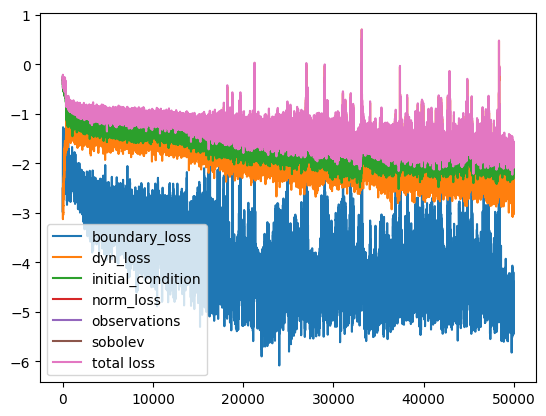

In [16]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


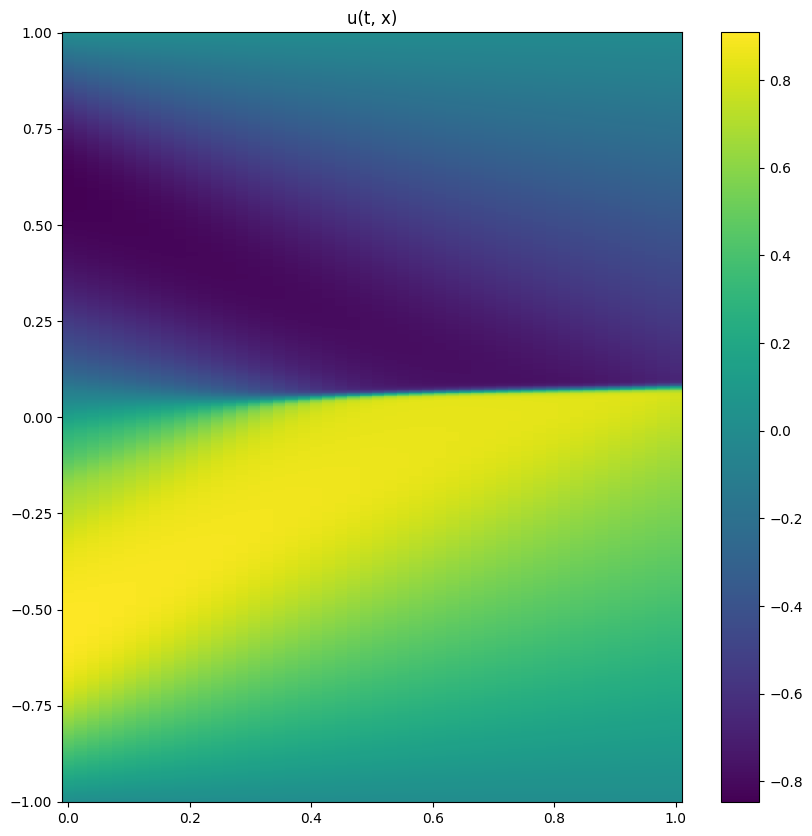

In [17]:
Tmax = 1
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

u_est = partial(u, params=params["nn_params"])

jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="u(t, x)")


## The stationary case

In case of a stationnary PDE, you may replace 
 * The PINN creation by the following call: `jinns.utils.create_PINN(key, eqx_list, eq_type="statio_PDE", dim_x=1)` which returns a PINN object with the `__call__` function to call `u(x, params)` without the `t` input. The dimension of the first layer of the network must be equal to $d$ in this case.
 * The `DataGenerator` in order to return only batch on $\Omega \times \partial \Omega$. See `CubicMeshPDEStatio` class.
 * The `LossPDENonStatio` class by the `LossPDEStatio` class (see the documentation and examples)

## Solving inverse PDE problems with jinns

**Warning:** this part of the package is still experimental.

